<h1> Loan Defaulter <span class="tocSkip"></span></h1>

<h1> Задача: <span class="tocSkip"></span></h1>

Осуществить предобработку данных, в том числе уменьшение размерности, использовать модели машинного обучения для классификации. 

Датасет: https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score

import lightgbm as ltb 
from lightgbm import LGBMClassifier

from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Loan_Defaulter/application_data.csv')
df_description = pd.read_csv('/content/drive/MyDrive/Loan_Defaulter/columns_description.csv')
df_prev = pd.read_csv('/content/drive/MyDrive/Loan_Defaulter/previous_application.csv')

In [ ]:
df_train_copy = df_train.copy()

# Загрузка данных

Здесь содержатся описания колонок в двух Датафреймах.

In [ ]:
df_description.head(10)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_data,CODE_GENDER,Gender of the client,NaN
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_data,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_data,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_data,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_data,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_data,AMT_ANNUITY,Loan annuity,NaN


In [ ]:
df_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   160 non-null    int64 
 1   Table        160 non-null    object
 2   Row          160 non-null    object
 3   Description  160 non-null    object
 4   Special      69 non-null     object
dtypes: int64(1), object(4)
memory usage: 6.4+ KB


Посмотрим, что за столбец  Special ... 

In [ ]:
df_description[df_description['Special'].isna() != True].sample(10)

,Unnamed: 0,Table,Row,Description,Special
49,52,application_data,ELEVATORS_AVG,Normalized information about building where th...,normalized
89,92,application_data,WALLSMATERIAL_MODE,Normalized information about building where th...,normalized
41,44,application_data,EXT_SOURCE_1,Normalized score from external data source,normalized
82,85,application_data,LIVINGAPARTMENTS_MEDI,Normalized information about building where th...,normalized
18,21,application_data,DAYS_EMPLOYED,How many days before the application the perso...,time only relative to the application
68,71,application_data,LIVINGAPARTMENTS_MODE,Normalized information about building where th...,normalized
88,91,application_data,TOTALAREA_MODE,Normalized information about building where th...,normalized
67,70,application_data,LANDAREA_MODE,Normalized information about building where th...,normalized
66,69,application_data,FLOORSMIN_MODE,Normalized information about building where th...,normalized
33,36,application_data,HOUR_APPR_PROCESS_START,Approximately at what hour did the client appl...,rounded


In [ ]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Тк данных очень много, то будем использовать выборку из 100.000 строк для более быстрого обучения. Выборочных. 

In [ ]:
df_train = df_train.sample(100_000)

In [ ]:
df_train.head(7)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
274060,417676,0,Cash loans,F,N,Y,0,292500.0,945000.0,40036.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
136205,257989,0,Cash loans,F,N,Y,0,180000.0,1078200.0,31653.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,4.0
123313,243005,0,Cash loans,F,Y,Y,1,270000.0,640080.0,29839.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
135773,257474,0,Cash loans,F,N,Y,0,112500.0,274500.0,14143.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
263238,404799,0,Cash loans,F,N,Y,0,157500.0,170640.0,11533.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,8.0
165639,292012,0,Cash loans,M,N,Y,0,117000.0,225000.0,10620.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
304724,453045,0,Cash loans,F,N,Y,1,216000.0,1078200.0,38331.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 93.8+ MB


# Предобработка

## Удаление столбцов с пропусками более 50%

Поставим опции для вывода всех столбцов.

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

Выведем количество пропусков в процентах по каждому признаку. 

In [ ]:
round(df_train.isnull().sum()*100/len(df_train.index),1)

SK_ID_CURR                       0.0
TARGET                           0.0
NAME_CONTRACT_TYPE               0.0
CODE_GENDER                      0.0
FLAG_OWN_CAR                     0.0
FLAG_OWN_REALTY                  0.0
CNT_CHILDREN                     0.0
AMT_INCOME_TOTAL                 0.0
AMT_CREDIT                       0.0
AMT_ANNUITY                      0.0
AMT_GOODS_PRICE                  0.1
NAME_TYPE_SUITE                  0.4
NAME_INCOME_TYPE                 0.0
NAME_EDUCATION_TYPE              0.0
NAME_FAMILY_STATUS               0.0
NAME_HOUSING_TYPE                0.0
REGION_POPULATION_RELATIVE       0.0
DAYS_BIRTH                       0.0
DAYS_EMPLOYED                    0.0
DAYS_REGISTRATION                0.0
DAYS_ID_PUBLISH                  0.0
OWN_CAR_AGE                     66.0
FLAG_MOBIL                       0.0
FLAG_EMP_PHONE                   0.0
FLAG_WORK_PHONE                  0.0
FLAG_CONT_MOBILE                 0.0
FLAG_PHONE                       0.0
F

Удалим столбцы-признаки, где пропусков больше 50 %. 

In [ ]:
df_train_isna_percentage = round(df_train.isnull().sum()*100/len(df_train.index),1)
df_train_isna_percentage = df_train_isna_percentage[df_train_isna_percentage.values > 50.0]
df_train_isna_percentage

OWN_CAR_AGE                 66.0
EXT_SOURCE_1                56.6
APARTMENTS_AVG              50.8
BASEMENTAREA_AVG            58.5
YEARS_BUILD_AVG             66.6
COMMONAREA_AVG              69.9
ELEVATORS_AVG               53.3
ENTRANCES_AVG               50.4
FLOORSMIN_AVG               67.9
LANDAREA_AVG                59.5
LIVINGAPARTMENTS_AVG        68.4
LIVINGAREA_AVG              50.2
NONLIVINGAPARTMENTS_AVG     69.5
NONLIVINGAREA_AVG           55.2
APARTMENTS_MODE             50.8
BASEMENTAREA_MODE           58.5
YEARS_BUILD_MODE            66.6
COMMONAREA_MODE             69.9
ELEVATORS_MODE              53.3
ENTRANCES_MODE              50.4
FLOORSMIN_MODE              67.9
LANDAREA_MODE               59.5
LIVINGAPARTMENTS_MODE       68.4
LIVINGAREA_MODE             50.2
NONLIVINGAPARTMENTS_MODE    69.5
NONLIVINGAREA_MODE          55.2
APARTMENTS_MEDI             50.8
BASEMENTAREA_MEDI           58.5
YEARS_BUILD_MEDI            66.6
COMMONAREA_MEDI             69.9
ELEVATORS_

In [ ]:
len(df_train_isna_percentage)

41

In [ ]:
df_train = df_train.drop(columns = df_train_isna_percentage.index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   99996 non-null   float64
 10  AMT_GOODS_PRICE               99922 non-null   float64
 11  NAME_TYPE_SUITE               99593 non-null   object 
 12  NAME_INCOME_TYPE              100000 no

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   99996 non-null   float64
 10  AMT_GOODS_PRICE               99922 non-null   float64
 11  NAME_TYPE_SUITE               99593 non-null   object 
 12  NAME_INCOME_TYPE              100000 no

Отлично. Было 122 колонки, мы удалили 41 колонку, осталась 81 колонка. Ок. 

## Заполнение пропусков

### Числовые типы

Заполним пропуски медианными значениями. Напишем общую функцию для этого.

In [ ]:
def column_median(column):
  df_train[column]=df_train[column].fillna(df_train[column].median())

In [ ]:
df_train.isna().sum().index

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_AVG', 'FLOOR

In [ ]:
isna_columns_for_median = list(df_train.isna().sum().index)
isna_columns_for_median

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE'

In [ ]:
column_median(isna_columns_for_median)

<ipython-input-21-75a2b40a4235>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train[column]=df_train[column].fillna(df_train[column].median())


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   100000 non-null  float64
 10  AMT_GOODS_PRICE               100000 non-null  float64
 11  NAME_TYPE_SUITE               99593 non-null   object 
 12  NAME_INCOME_TYPE              100000 no

Видим, что все колонки с числовыми типами заполнились. 

### Строковые типы

Тогда заполним колонки типа object на самое частое значение. Сначала получим список колонок с пропусками.

In [ ]:
object_columns = list(df_train.select_dtypes(include=['object']).columns)
#print(object_columns)
df_object_columns = df_train.loc[:,object_columns]
df_object_columns.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   NAME_CONTRACT_TYPE          100000 non-null  object
 1   CODE_GENDER                 100000 non-null  object
 2   FLAG_OWN_CAR                100000 non-null  object
 3   FLAG_OWN_REALTY             100000 non-null  object
 4   NAME_TYPE_SUITE             99593 non-null   object
 5   NAME_INCOME_TYPE            100000 non-null  object
 6   NAME_EDUCATION_TYPE         100000 non-null  object
 7   NAME_FAMILY_STATUS          100000 non-null  object
 8   NAME_HOUSING_TYPE           100000 non-null  object
 9   OCCUPATION_TYPE             68624 non-null   object
 10  WEEKDAY_APPR_PROCESS_START  100000 non-null  object
 11  ORGANIZATION_TYPE           100000 non-null  object
 12  EMERGENCYSTATE_MODE         52594 non-null   object
dtypes: object(13)
memory usa

In [ ]:
d = df_object_columns.isna().sum() 
l_d = list(d[d.values != 0].index)
l_d

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE']

In [ ]:
df_train['NAME_TYPE_SUITE']=df_train['NAME_TYPE_SUITE'].fillna(df_train['NAME_TYPE_SUITE'].mode()[0])
df_train['OCCUPATION_TYPE']=df_train['OCCUPATION_TYPE'].fillna(df_train['OCCUPATION_TYPE'].mode()[0])
df_train['EMERGENCYSTATE_MODE']=df_train['EMERGENCYSTATE_MODE'].fillna(df_train['EMERGENCYSTATE_MODE'].mode()[0])

In [ ]:
df_train.isna().sum()

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   100000 non-null  float64
 10  AMT_GOODS_PRICE               100000 non-null  float64
 11  NAME_TYPE_SUITE               100000 non-null  object 
 12  NAME_INCOME_TYPE              100000 no

## Кодирование категориальных признаков

In [ ]:
df_train = pd.get_dummies(df_train,drop_first=True)
df_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_P

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 274060 to 231219
Columns: 180 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(27), int64(41), uint8(112)
memory usage: 63.3 MB


## Разделение на выборки

In [ ]:
X = df_train.drop(columns = ['TARGET'])
y = df_train['TARGET']

In [ ]:
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.20, random_state=111222, stratify=y)

In [ ]:
X_train.shape, X_valid.shape

((80000, 179), (20000, 179))

## Удаление неважных признаков

Посмотрим на важность признаков 

In [ ]:
importances = mutual_info_classif(X_train, y_train)
feature_importances = pd.Series(importances, X_train.columns[0:len(X_train.columns)])
feature_importances

SK_ID_CURR                                           0.000000
CNT_CHILDREN                                         0.000000
AMT_INCOME_TOTAL                                     0.001484
AMT_CREDIT                                           0.007420
AMT_ANNUITY                                          0.011860
AMT_GOODS_PRICE                                      0.003436
REGION_POPULATION_RELATIVE                           0.001546
DAYS_BIRTH                                           0.005584
DAYS_EMPLOYED                                        0.008034
DAYS_REGISTRATION                                    0.000670
DAYS_ID_PUBLISH                                      0.003113
FLAG_MOBIL                                           0.015368
FLAG_EMP_PHONE                                       0.013661
FLAG_WORK_PHONE                                      0.000990
FLAG_CONT_MOBILE                                     0.015505
FLAG_PHONE                                           0.001099
FLAG_EMA

Видим, что часть признако вообще не имеет значения. Удалим признаки с важностью меньше 0.0035. Эмпирическим путем.

In [ ]:
sort_feature_importances = feature_importances.sort_values()
sort_feature = sort_feature_importances[sort_feature_importances.values > 0.0035]
drop_feature = sort_feature_importances[sort_feature_importances.values <= 0.0035]
drop_feature

SK_ID_CURR                                  0.000000
ORGANIZATION_TYPE_Industry: type 10         0.000000
CODE_GENDER_XNA                             0.000000
ORGANIZATION_TYPE_Hotel                     0.000000
ORGANIZATION_TYPE_Culture                   0.000000
ORGANIZATION_TYPE_Construction              0.000000
ORGANIZATION_TYPE_Business Entity Type 3    0.000000
WEEKDAY_APPR_PROCESS_START_SUNDAY           0.000000
OCCUPATION_TYPE_Waiters/barmen staff        0.000000
OCCUPATION_TYPE_Private service staff       0.000000
OCCUPATION_TYPE_Managers                    0.000000
OCCUPATION_TYPE_IT staff                    0.000000
OCCUPATION_TYPE_High skill tech staff       0.000000
OCCUPATION_TYPE_HR staff                    0.000000
OCCUPATION_TYPE_Cooking staff               0.000000
OCCUPATION_TYPE_Cleaning staff              0.000000
FLAG_DOCUMENT_10                            0.000000
FLAG_DOCUMENT_11                            0.000000
FLAG_DOCUMENT_12                            0.

Визуализируем важность оставшихся признаков.

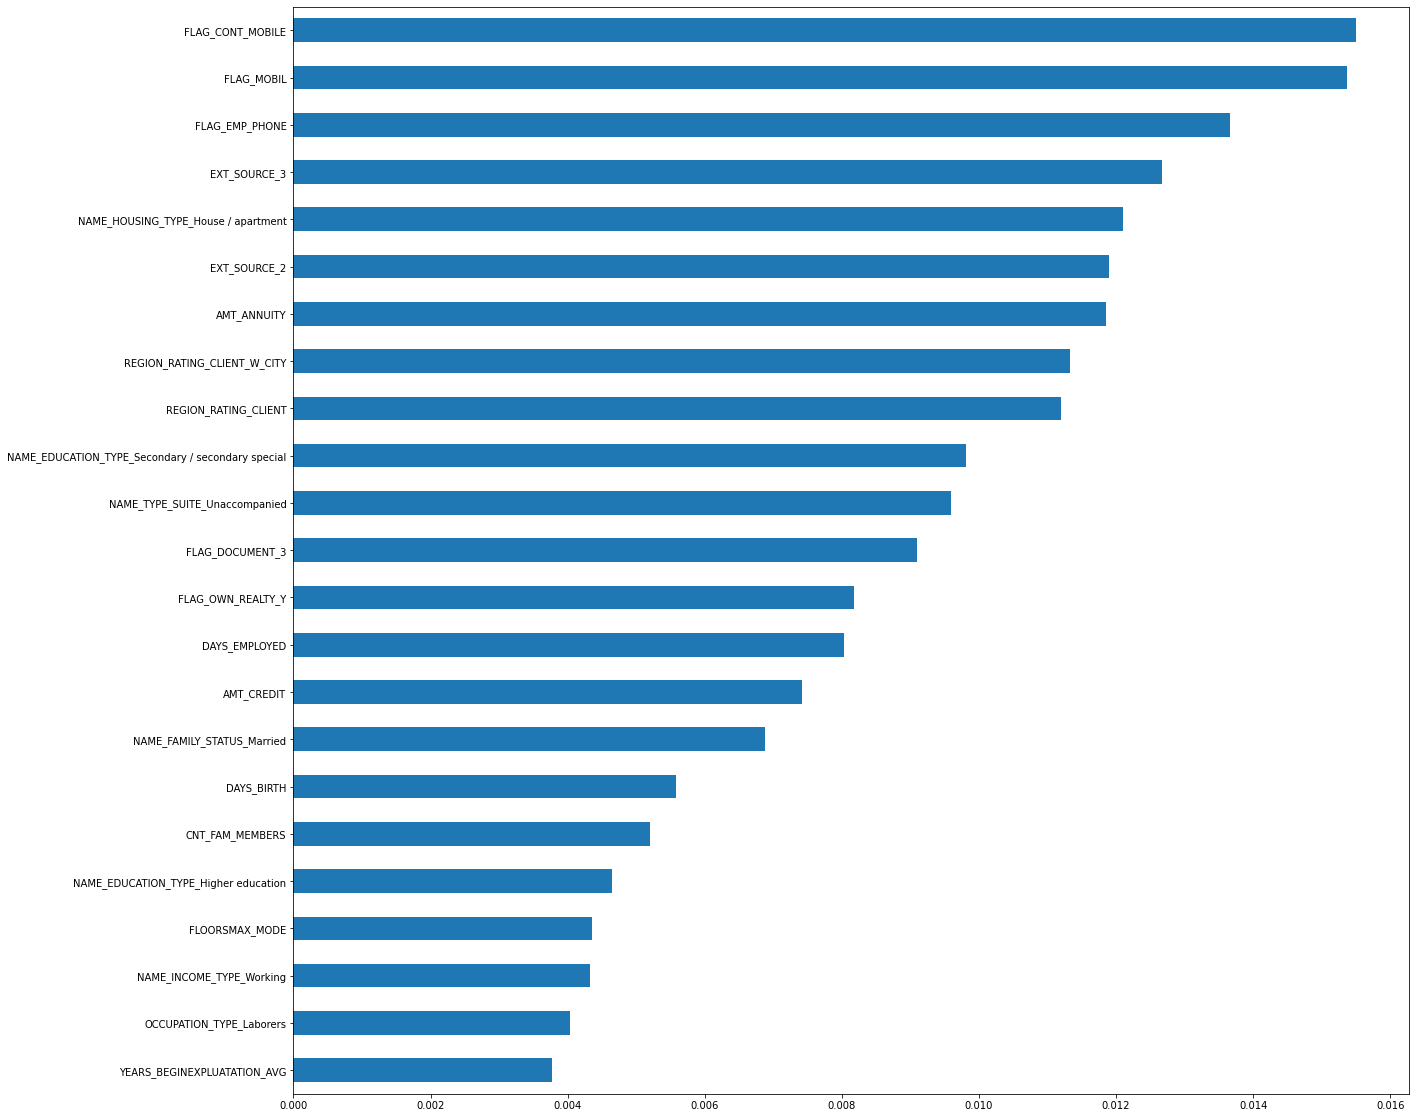

In [ ]:
plt.figure(figsize=(20,20))
sort_feature.plot(kind='barh')
plt.show()

In [ ]:
len(X_train.columns), len(drop_feature.index)

(179, 156)

In [ ]:
X_train = X_train.drop(columns = drop_feature.index)
X_valid = X_valid.drop(columns = drop_feature.index)
len(X_train.columns)

23

## Масштабирование признаков

In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns
numeric = set(X_train.columns) - set(object_columns)
numeric = list(numeric)
#numeric

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_train.sample(10)

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_MODE,FLAG_DOCUMENT_3,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Laborers
226050,-1.121340,-1.118313,0.331319,-0.459388,0.0,0.471653,0.043917,0.926852,-0.100008,-0.058035,0.567105,0.524609,0.045808,-0.267076,0.637976,0.667403,0.484361,0.969078,1.761350,-1.569603,0.752464,0.355745,-0.987429
188556,-0.676403,-0.351743,1.304768,-0.456335,0.0,0.471653,0.043917,-1.266588,-0.100008,-0.058035,0.815126,0.109748,0.213766,1.296299,0.637976,-1.498346,0.484361,0.969078,-0.567746,0.637104,-1.328968,0.355745,1.012731
266227,1.195762,0.316557,-0.132522,-0.483301,0.0,0.471653,0.043917,0.926852,-0.100008,-0.058035,-0.447979,-0.344632,-0.131749,-0.267076,0.637976,-1.498346,0.484361,0.969078,-0.567746,0.637104,0.752464,0.355745,1.012731
253417,0.522299,-0.108866,1.507741,-0.472550,0.0,0.471653,0.043917,-0.169868,-0.100008,-0.058035,-0.665236,0.109748,0.009816,-1.440077,0.637976,0.667403,0.484361,0.969078,1.761350,-1.569603,0.752464,0.355745,-0.987429
255200,0.564268,-0.195319,-1.028854,2.120235,0.0,-2.120203,0.043917,-1.266588,-0.100008,-0.058035,0.724058,-0.911794,0.045808,-0.267076,0.637976,0.667403,0.484361,-1.031909,-0.567746,0.637104,-1.328968,0.355745,1.012731
26286,-0.257754,0.424156,-0.839382,2.120235,0.0,-2.120203,0.043917,0.926852,1.867204,1.934598,-1.427043,-1.520496,0.045808,-0.267076,-1.567456,-1.498346,0.484361,-1.031909,-0.567746,0.637104,0.752464,0.355745,1.012731
38229,-0.809462,0.008374,0.007752,-0.491246,0.0,0.471653,0.043917,2.023571,-0.100008,-0.058035,1.216016,0.109748,-0.179737,-1.049703,0.637976,-1.498346,0.484361,0.969078,-0.567746,0.637104,0.752464,0.355745,-0.987429
218825,-0.133039,-0.115086,0.771820,-0.464309,0.0,0.471653,0.043917,-0.169868,-0.100008,-0.058035,0.308329,-1.088676,0.045808,-0.267076,0.637976,-1.498346,0.484361,-1.031909,-0.567746,0.637104,0.752464,0.355745,-0.987429
116436,1.195762,0.316557,0.228803,-0.464816,0.0,0.471653,0.043917,-0.169868,-0.100008,-0.058035,0.241269,0.709137,0.213766,1.687612,0.637976,0.667403,0.484361,0.969078,-0.567746,0.637104,-1.328968,0.355745,-0.987429
152310,-0.310691,1.655022,0.683491,-0.463752,0.0,0.471653,0.043917,-1.266588,-0.100008,-0.058035,0.609432,0.109748,-0.071763,-1.831391,0.637976,0.667403,0.484361,0.969078,-0.567746,0.637104,-1.328968,0.355745,1.012731


## Уменьшение размерности

In [ ]:
#!pip install tsnecuda
#from tsnecuda import TSNE

In [ ]:
#pca = PCA(10)
#transformed_vectors = pca.fit_transform(X_train)

Возьмем perplexity=100, так как этот параметр связан с количеством соседей, которые ищутся поблизости. У нас в TARGET всего 2 значения, поэтому кажется, что perplexity стоит взять побольше, чем дефолтное значение равное 30.

In [ ]:
X_train_embedded = TSNE(n_components=2, perplexity=100, learning_rate = 'auto', n_jobs = -1).fit_transform(X_train[:10000])
X_train_embedded.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(10000, 2)

In [ ]:
X_train_embedded[:, 0].shape, X_train_embedded[:, 1].shape, y_train[:10000].shape

((10000,), (10000,), (10000,))

Визуализируем то, что у нас получилось 

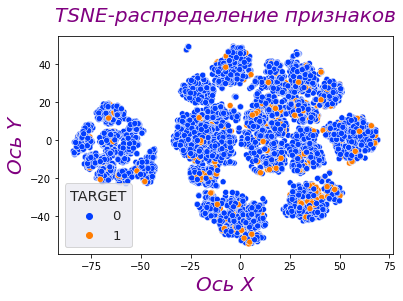

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = X_train_embedded[:, 0], y = X_train_embedded[:, 1], hue=y_train[:10000], palette='bright')
ax.set_title('TSNE-распределение признаков', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

# Обучение моделей

### Логистическая регрессия

In [ ]:
random_state = 111222

In [ ]:
params = dict(
    C = [100, 10, 1, 0.1, 0.01, 0.001],
    penalty=['l1', 'l2', 'elasticnet'],
    solver=['saga'],
    multi_class =['auto', 'ovr', 'multinomial'],
    l1_ratio=[1]
)

In [ ]:
lr = LogisticRegression()
lr = RandomizedSearchCV(lr, params, n_jobs=-1, cv=5, random_state=random_state)
lr.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                                        'l1_ratio': [1],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']},
                   random_state=111222)

In [ ]:
best_params = lr.best_params_
best_params

{'solver': 'saga',
 'penalty': 'l2',
 'multi_class': 'multinomial',
 'l1_ratio': 1,
 'C': 0.001}

In [ ]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  f1 = f1_score(y, lr.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  #print(f'F1 {label}={f1_score(y, lr.predict(X), average='micro'):.3f}')   
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.920
F1 train=0.92
ROC_AUC train=0.721

Acc test=0.920
F1 test=0.92
ROC_AUC test=0.730



In [ ]:
print(classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73571
           1       0.55      0.00      0.00      6429

    accuracy                           0.92     80000
   macro avg       0.73      0.50      0.48     80000
weighted avg       0.89      0.92      0.88     80000



In [ ]:
print(classification_report(y_valid, lr.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18393
           1       0.40      0.00      0.00      1607

    accuracy                           0.92     20000
   macro avg       0.66      0.50      0.48     20000
weighted avg       0.88      0.92      0.88     20000



### Случайный лес

In [ ]:
params = dict(
    n_estimators = range(5, 150, 5),
    min_samples_split = range(1, 20, 2),
    min_samples_leaf = range(1, 20, 2),
    max_samples = np.linspace(0, 1, 20)#,    class_weight = 'balanced'
)

In [ ]:
rf = RandomForestClassifier()
rf = RandomizedSearchCV(rf, params, n_jobs=-1, cv=5, random_state=random_state)
rf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", l

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_samples': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                                        'min_samples_leaf': range(1, 20, 2),
                                        'min_samples_split': range(1, 20, 2),
                                        'n_estimators': range(5, 150, 5)},
                   random_state=111222)

In [ ]:
best_params = rf.best_params_
best_params

{'n_estimators': 115,
 'min_samples_split': 5,
 'min_samples_leaf': 13,
 'max_samples': 0.15789473684210525}

In [ ]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = rf.predict(X)
  f1 = f1_score(y, rf.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  #print(f'F1 {label}={f1_score(y, rf.predict(X), average='micro'):.3f}')   
  print(f'ROC_AUC {label}={roc_auc_score(y, rf.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.920
F1 train=0.92
ROC_AUC train=0.805

Acc test=0.920
F1 test=0.92
ROC_AUC test=0.731



In [ ]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73571
           1       0.00      0.00      0.00      6429

    accuracy                           0.92     80000
   macro avg       0.46      0.50      0.48     80000
weighted avg       0.85      0.92      0.88     80000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_valid, rf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18393
           1       0.00      0.00      0.00      1607

    accuracy                           0.92     20000
   macro avg       0.46      0.50      0.48     20000
weighted avg       0.85      0.92      0.88     20000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LGBMClassifier

In [ ]:
params = dict(n_estimators = range (100, 200, 50),
    colsample_bytree= [0.7, 0.8],
    max_depth = range (10, 100, 20),
    num_leaves = [50, 100, 200],
    reg_alpha = [1.1, 1.2, 1.3],
    reg_lambda = [1.1, 1.2, 1.3],
    min_split_gain  = [0.3, 0.4],
    subsample = [0.7, 0.8, 0.9],
    subsample_freq= [20])

In [ ]:
lg = LGBMClassifier()
lg = RandomizedSearchCV(lg, params, n_jobs=-1, cv=5, random_state=random_state)
lg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8],
                                        'max_depth': range(10, 100, 20),
                                        'min_split_gain': [0.3, 0.4],
                                        'n_estimators': range(100, 200, 50),
                                        'num_leaves': [50, 100, 200],
                                        'reg_alpha': [1.1, 1.2, 1.3],
                                        'reg_lambda': [1.1, 1.2, 1.3],
                                        'subsample': [0.7, 0.8, 0.9],
                                        'subsample_freq': [20]},
                   random_state=111222)

In [ ]:
best_params = lg.best_params_
best_params

{'subsample_freq': 20,
 'subsample': 0.9,
 'reg_lambda': 1.1,
 'reg_alpha': 1.1,
 'num_leaves': 50,
 'n_estimators': 100,
 'min_split_gain': 0.4,
 'max_depth': 10,
 'colsample_bytree': 0.7}

In [ ]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lg.predict(X)
  f1 = f1_score(y, lg.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  #print(f'F1 {label}={f1_score(y, lg.predict(X), average='micro'):.3f}')   
  print(f'ROC_AUC {label}={roc_auc_score(y, lg.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.921
F1 train=0.921
ROC_AUC train=0.828

Acc test=0.920
F1 test=0.92
ROC_AUC test=0.737



In [ ]:
print(classification_report(y_train, lg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73571
           1       0.87      0.02      0.05      6429

    accuracy                           0.92     80000
   macro avg       0.90      0.51      0.50     80000
weighted avg       0.92      0.92      0.89     80000



In [ ]:
print(classification_report(y_valid, lg.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18393
           1       0.54      0.01      0.03      1607

    accuracy                           0.92     20000
   macro avg       0.73      0.51      0.49     20000
weighted avg       0.89      0.92      0.88     20000



# Вывод

Из исходного датасета было взято 100 тысяч строк выборочно. В противном случае, модели обучались крайне долго. 
Была прозиведена предобработка данных:
1. Удаление столбоцов с пропусками более 50%. 
Из первоначальных 122 столбцов остался 81 столбец.
2. Заполнение оставшихся пропусков в числовых признаках на медианное значение по столбцу, а в категориальных признаках - на моду. 
3. Произведено кодировние категориальных признаков.
Из 81 столбца стало 180 столбцов. 
4. Далее - разделение на обучающую и тестовую выборки.
В фичах 179 столбцов соответственно.
5. Построена матрица важности признаков по отношению к целевому признаку, и удалены наиболее неважные признаки.
Из 179 столбцов осталось 23 наиболее значимых столбца.
6. Произведено масштабирование признаков. 

Далее: 
7. Сделано уменьшение размерности с помощью TSNE (использовалась выборка из 10 тыс.строк). На визуализации четкие кластеры по целевому признаку не выделяются.
Perplexity было взято равным 100, так как этот параметр связан с количеством соседей, которые ищутся поблизости. У нас в TARGET всего 2 значения, поэтому кажется, что perplexity стоит взять побольше, чем дефолтное значение равное 30.

Затем:
8. Были обучены четыре модели классификации с предварительным поиском гиперпараметров с помощью RandomizedSearchCV: Логистическая регрессия, Случайный лес и LGBMClassifier. 

Все модели на валидационной выборке показали примерно одинаковый скор:

Accuracy = 0.92;

F1 = 0.92 ;

ROC-AUC = 0.737.